# Expert Design Plan for generating a gm/ID Look-Up Table

## Introduction

This notebook demonstrates the basic functionality of the Expert Design Plan (EDP) Toolbox in Python. For a short introdcution, an EDP is shown with which the $\frac{g_{\mathrm{m}}}{I_{\mathrm{D}}}$ Look-Up Table (LUT) for the NMOS Transistor of the XT018 PDK is generated.

![](fig/nmos-char.png)

**NOTE:** Ensure the `jupyter lab` or any other editor is launched from a shell where the environment variables are set.

In [1]:
import edp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objs as go

In [2]:
plotly.offline.init_notebook_mode()

## The Database

Initialize the Design Database. This is based on the settings defined in you `.edpinit.json`:

```json
{ "cdsWorkDir":    "path/to/where/virtuoso/is/launched"
, "logDir":        "make/sure/this/path/exists/"
, "appendLogfile": false
, "techFiles":     [ "/some/path/to/edp-pdk-xt018/edp-pdk-xt018.xml"
                   , "/some/path/to/edp-pdk-cds/edp-pdk-cds.xml" ]
, "predictDBs":    []
, "workLibs":      ["edp_dsgn", "edp_tb"]
, "evalLib":       "evalLib"
, "simDir":        "/make/sure/this/path/exists"
, "simTimeout":    10
, "session":       true
, "infoMessages":  false
, "debugMessages": false
}
```

It is important that the technology files are accessible and that all paths are set correctly.

In [3]:
db = edp.Database.init('.edpinit.json')

*WARNING* (DB-0317) @ 2024-05-01 17:03:26
  Cannot create logfile at @ "/tmp/uhlmann_log", print only to console
*INFO* (DB-0273) @ 2024-05-01 17:03:26
  Establised interactive session @ /home/uhlmanny/Workspace/edp/playground
*INFO* (TECH-0009) @ 2024-05-01 17:03:26
  Reading technology file /home/uhlmanny/Workspace/edp/edp-pdk-cds/edp-pdk-cds.xml ...
*INFO* (TECH-0020) @ 2024-05-01 17:03:26
  Reading of technology "cadence" is finished
*INFO* (TECH-0009) @ 2024-05-01 17:03:26
  Reading technology file /home/uhlmanny/Workspace/edp/edp-pdk-xt018/edp-pdk-xt018.xml ...
*INFO* (TECH-0020) @ 2024-05-01 17:03:26
  Reading of technology "xt018" is finished
*INFO* (DB-0034) @ 2024-05-01 17:03:26
  Use library "edp_eval" as evaluation library
*INFO* (DB-0059) @ 2024-05-01 17:03:26
  Import cell edp_test/res_div and pins = [A, B, M]
*INFO* (DB-0059) @ 2024-05-01 17:03:26
  Import cell edp_test/inv and pins = [OUT, VDD, VSS, IN]
*INFO* (DB-0024) @ 2024-05-01 17:03:26
  Imported View edp_test/res

## Netlist

Eventhough the _netlist_ is part of the OpenAccess standard, Virtuoso does not provide a way to edit them. However they are part of the design database and can be created with EDP.

In [4]:
tb = db.createNetlist()

Here the parameters constraining the sweeps are defined, just as you would at the top of a netlist.

In [5]:
w: float     = 10e-6
vdd: float   = 1.8
l_min: float = 1e-6
l_max: float = 10e-6
n_steps: int = 4

## Instantiating Devices

A Transistor is added to the netlist using the `addPrimitive` method of the netlist. The instace parameters are modified using the `set` function.

In [6]:
nmos = tb.addPrimitive('M0', 'PRIMLIB', 'ne', ['D', 'G', 'gnd!', 'B'])
_    = nmos.set('width', w)

Similarly, components from Cadence's `analogLib`, such as voltage sources, are instantiated with the `addPrimitive` method.

In [7]:
_ = tb.addPrimitive('VDS', 'analogLib', 'vdc', ['D', 'gnd!'])
_ = tb.addPrimitive('VGS', 'analogLib', 'vdc', ['G', 'gnd!'])
_ = tb.addPrimitive('VBS', 'analogLib', 'vdc', ['B', 'gnd!'])

## Creating Tests

With all components instantiated, a `test` is defined using the _spectre_ circuit simulator.

In [8]:
test = db.createTest('spectre', tb)

## Saving Operating Point Parameters

For the $\frac{g_{\mathrm{m}}}{I_{\mathrm{D}}}$ LUT the following DC operating point characteristics of the XT018's NMOS will be saved.

In [9]:
ops = [ 'vds', 'vgs', 'vbs', 'vth', 'vdsat', 'id'
      , 'gmoverid', 'gm', 'gds', 'self_gain', 'fug', 'region' ]
_   = [test.save(test.getInstance('M0').getOperatingPoint(op)) for op in ops]

## Adding Analyses

Next a DC Operating Point (`dcop`) analysis is added to the test with the `addAnalysis` method.

In [10]:
dcop = test.addAnalysis('dcop', 'op')

## Running Simulations

With this utility function `op_point` the operating point for the DUT is specified. It takes the 4 sweep variables and modifies the transistor instance using the `set` method. Subsequently, a simulation is run with the `simulate` method from which the desired characteristics are obtained. This is returned as a `pandas` DataFrame with a single row.

In [11]:
def op_point(l,vgs,vds,vbs):
    _   = test.getInstance('VGS').set('vdc', vgs)
    _   = test.getInstance('VDS').set('vdc', vds)
    _   = test.getInstance('VBS').set('vdc', vbs)
    _   = test.getInstance('M0').set('length', l)
    rdb = test.simulate().getResults(dcop)
    dat = { p: [rdb.get(test.getInstance('M0').getOperatingPoint(p))]
            for p in ops
          } | {'L': l, 'W': w}
    return pd.DataFrame.from_dict(dat)

Here we loop over the cartesian product of the 4 sweep variables and concatenate the result into a single DataFrame: **The Look-Up Table**

In [12]:
df = pd.concat( [ op_point(l,g,d,b) 
                  for b in list(np.linspace(0.0,-(vdd*0.85),n_steps))
                  for d in list(np.linspace(0.0,vdd,n_steps)) 
                  for g in list(np.linspace(0.0,vdd,n_steps))
                  for l in list(np.logspace(l_min,l_max,n_steps))]
              , axis = 0
              , ignore_index = True)

## Processing Results

From this LUT we can extract the different regions of operation using the `region` column that was saved.

In [13]:
sat = df[(df.vbs == 0.0) & (df.region == 2.0)]
tri = df[(df.vbs == 0.0) & (df.region == 1.0)]
off = df[(df.vbs == 0.0) & (df.region == 0.0)]
sub = df[(df.vbs == 0.0) & (df.region == 3.0)]

## Creating Plots

In the following the transfer- and output characteristic of the XT018's NMOS transistor is visualized, where the points are colored according to their region of operation.

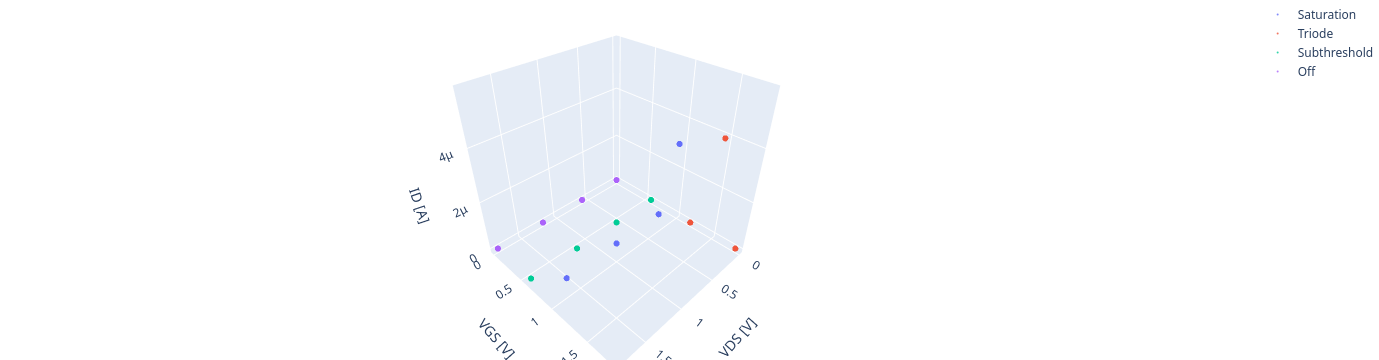

In [14]:
plot_mark   = { 'size': 2, 'opacity': 0.8 }
plot_layout = go.Layout( margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
                         scene  = { 'xaxis' : {'title' : 'VDS [V]'}
                                  , 'yaxis' : {'title' : 'VGS [V]'}
                                  , 'zaxis' : {'title' : 'ID [A]' } } )

trace_sat = go.Scatter3d(x = sat.vds, y = sat.vgs, z = sat.id, mode = 'markers', marker = plot_mark, name = 'Saturation')
trace_tri = go.Scatter3d(x = tri.vds, y = tri.vgs, z = tri.id, mode = 'markers', marker = plot_mark, name = 'Triode')
trace_sub = go.Scatter3d(x = sub.vds, y = sub.vgs, z = sub.id, mode = 'markers', marker = plot_mark, name = 'Subthreshold')
trace_off = go.Scatter3d(x = off.vds, y = off.vgs, z = off.id, mode = 'markers', marker = plot_mark, name = 'Off')


plot_data = [trace_sat, trace_tri, trace_sub, trace_off]

plot_figure = go.Figure(data = plot_data, layout = plot_layout)

plotly.offline.iplot(plot_figure)

In case plotly is not available, it may be also plotted statically, using `matplotlib`.

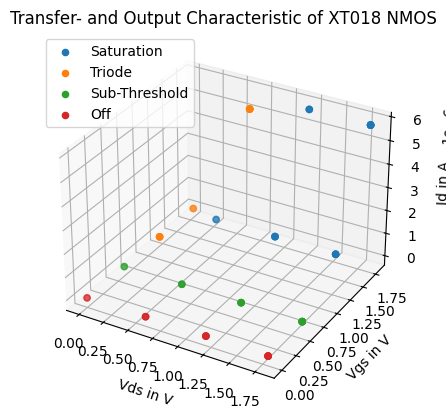

In [15]:
ax = plt.axes(projection = "3d")
_  = ax.set_xlabel('Vds in V')
_  = ax.set_ylabel('Vgs in V')
_  = ax.set_zlabel('Id in A')
_  = ax.set_title('Transfer- and Output Characteristic of XT018 NMOS')
_  = ax.scatter3D(sat.vds, sat.vgs, sat.id, label = 'Saturation')
_  = ax.scatter3D(tri.vds, tri.vgs, tri.id, label = 'Triode')
_  = ax.scatter3D(sub.vds, sub.vgs, sub.id, label = 'Sub-Threshold')
_  = ax.scatter3D(off.vds, off.vgs, off.id, label = 'Off')
_  = plt.legend()
plt.show()

## Closing

It is good practice to manually quit the data base when it is no longer needed. This ensures that everything is saved. The constructor also takes care of quitting if this is not done explicitly, whenever the data base object leves the scope.

In [16]:
db.quit()

*INFO* (DB-0011) @ 2024-05-01 17:03:29
  Quit database


'True'